In [1]:
import argparse
import traceback
import pytorch_lightning as pl
from pytorch_lightning.utilities import rank_zero_info
import models
import tasks
import utils.callbacks
import utils.data
import utils.email
import utils.logging
import torch

In [2]:
DATA_PATHS = {
    "shenzhen": {"feat": "data/sz_speed.csv", "adj": "data/sz_adj.csv"},
    "losloop": {"feat": "data/los_speed.csv", "adj": "data/los_adj.csv"},
}


def get_model(args, dm):
    model = None
    if args.model_name == "GCN":
        model = models.GCN(adj=dm.adj, input_dim=args.seq_len, output_dim=args.hidden_dim)
    if args.model_name == "GRU":
        model = models.GRU(input_dim=dm.adj.shape[0], hidden_dim=args.hidden_dim)
    if args.model_name == "TGCN":
        model = models.TGCN(adj=dm.adj, hidden_dim=args.hidden_dim)
    return model


def get_task(args, model, dm):
    task = getattr(tasks, args.settings.capitalize() + "ForecastTask")(
        model=model, feat_max_val=dm.feat_max_val, **vars(args)
    )
    return task


def get_callbacks(args):
    checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="train_loss")
    plot_validation_predictions_callback = utils.callbacks.PlotValidationPredictionsCallback(monitor="train_loss")
    callbacks = [
        checkpoint_callback,
        plot_validation_predictions_callback,
    ]
    return callbacks


def main_supervised(args):
    dm = utils.data.SpatioTemporalCSVDataModule(
        feat_path=DATA_PATHS[args.data]["feat"], adj_path=DATA_PATHS[args.data]["adj"], **vars(args)
    )
    model = get_model(args, dm)
    task = get_task(args, model, dm)
    callbacks = get_callbacks(args)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=callbacks)
    trainer.fit(task, dm)
    results = trainer.validate(datamodule=dm)
    return results, model,task, dm  


def main(args):
    rank_zero_info(vars(args))
    results, model,task, dm = globals()["main_" + args.settings](args)
    return results, model,task, dm

In [3]:
parser = argparse.ArgumentParser()
#parser = pl.Trainer.add_argparse_args(parser)

parser.add_argument("--max_epochs", default = 10)
parser.add_argument("--pre_len", type=int, default=3)
parser.add_argument("--val_batch_size", type=int, default=1)
#parser.add_argument("--learning_rate", default = 0.001)
#parser.add_argument("--weight_decay", default = 0)
#parser.add_argument("--batch_size", default =  32)
#parser.add_argument("--hidden_dim", default = 64)
#parser.add_argument("--loss", default = "mse_with_regularizer") 
parser.add_argument("--gpus", default =  1) 


parser.add_argument(
    "--data", type=str, help="The name of the dataset", choices=("shenzhen", "losloop"), default="shenzhen"
)
parser.add_argument(
    "--model_name",
    type=str,
    help="The name of the model for spatiotemporal prediction",
    choices=("GCN", "GRU", "TGCN"),
    default="TGCN",
)
parser.add_argument(
    "--settings",
    type=str,
    help="The type of settings, e.g. supervised learning",
    choices=("supervised",),
    default="supervised",
)
parser.add_argument("--log_path", type=str, default=None, help="Path to the output console log file")
parser.add_argument("--send_email", "--email", action="store_true", help="Send email when finished")

temp_args, _ = parser.parse_known_args()

parser = getattr(utils.data, temp_args.settings.capitalize() + "DataModule").add_data_specific_arguments(parser)
parser = getattr(models, temp_args.model_name).add_model_specific_arguments(parser)
parser = getattr(tasks, temp_args.settings.capitalize() + "ForecastTask").add_task_specific_arguments(parser)

args = parser.parse_args("")
utils.logging.format_logger(pl._logger)
if args.log_path is not None:
    utils.logging.output_logger_to_file(pl._logger, args.log_path)

results, model, task, dm = main(args)

[2022-02-16 10:35:48,385 INFO]{'max_epochs': 10, 'pre_len': 3, 'val_batch_size': 1, 'gpus': 1, 'data': 'shenzhen', 'model_name': 'TGCN', 'settings': 'supervised', 'log_path': None, 'send_email': False, 'batch_size': 32, 'seq_len': 12, 'split_ratio': 0.8, 'normalize': True, 'hidden_dim': 64, 'learning_rate': 0.001, 'weight_decay': 0.0015, 'loss': 'mse_with_regularizer'}
[2022-02-16 10:35:50,161 INFO]GPU available: True, used: True
[2022-02-16 10:35:50,162 INFO]TPU available: False, using: 0 TPU cores
[2022-02-16 10:35:50,163 INFO]IPU available: False, using: 0 IPUs
[2022-02-16 10:35:50,298 INFO]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
[2022-02-16 10:37:12,375 INFO]
  | Name      | Type   | Params
-------------------------------------
0 | model     | TGCN   | 12.7 K
1 | regressor | Linear | 195   
-------------------------------------
12.9 K    Trainable params
0         Non-trainable params
12.9 K    Total params
0.051     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:116: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1393: UserWarning: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `validate(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(
[2022-02-16 10:38:41,652 INFO]Restoring states from the checkpoint path at /blue/thai/minhvu/TGCN/lightning_logs/version_17/checkpoints/epoch=9-step=739.ckpt
[2022-02-16 10:38:41,692 INFO]LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
[2022-02-16 10:38:41,711 INFO]Loaded model weights from checkpoint at /blue/thai/minhvu/TGCN/lightning_logs/version_17/checkpoints/epoch=9-step=739.ckpt
/home/minhvu/blue_minhvu/Python_geometric/lib/python3.8/site-packages/pytorch_lightni

Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'ExplainedVar': 0.7000513076782227,
 'MAE': 4.248176574707031,
 'R2': 0.697997510433197,
 'RMSE': 5.720104694366455,
 'accuracy': 0.6006122827529907,
 'val_loss': 7725.22216796875}
--------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [4]:
#Clone regressor
#source_task: contain attributes model (TGCN) and regressor
#dest_task: clone only regressor part. 

dest_task = tasks.supervised.SupervisedForecastTask_clone(hidden_dim = args.hidden_dim)
source_task = task

task_clone_layers = []
for item in dest_task._modules.items():
    task_clone_layers.append(item[0])
    
source_task.eval()
dest_task.eval()
for layer in task_clone_layers: 
    if layer == "regressor":
        if hasattr(getattr(dest_task, layer), 'weight'):
            with torch.no_grad():
                getattr(dest_task, layer).weight.copy_(getattr(source_task, layer).weight)
        if hasattr(getattr(dest_task, layer), 'bias'):
            with torch.no_grad():
                getattr(dest_task, layer).bias.copy_(getattr(source_task, layer).bias)
            

In [5]:
adj = dm._adj # adjacent matrix for GCN
input_dim =  adj.shape[0] 
hidden_dim = args.hidden_dim # RNN hidden state dimension

source_model = source_task.model.tgcn_cell # source model we need to clone 
source_model.eval()

# Taking the sample and the model out
probe_sample = 10
sample = 0
for val_features, val_labels in dm.val_dataloader():
    
    if sample > probe_sample:
        break
    
    if sample == probe_sample:

        inputs = val_features
        batch_size, seq_len, num_nodes = inputs.shape
        assert input_dim == num_nodes
            
    sample += 1

In [6]:
probe_snapshot = 2
hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
output = None
for i in range(probe_snapshot):
    if i == probe_snapshot - 1:
        dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
        dest_model.eval()    
        clone_layers = []
        for item in source_task.model.tgcn_cell._modules.items():
            clone_layers.append(item[0])

        for layer in clone_layers:
            if hasattr(getattr(dest_model, layer), 'weights'):
                with torch.no_grad():
                    getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
            if hasattr(getattr(dest_model, layer), 'biases'):
                with torch.no_grad():
                    getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)
    
#         dest_output, dest_hidden_state = dest_model.forward(inputs[:, i, :])
#         dest_output = dest_output.reshape((batch_size, num_nodes, hidden_dim))
#         dest_prediction = dest_task.forward(dest_output)
#         source_output =  source_task.model(inputs[:,:i+1, :])
#         source_prediction = source_task.forward(inputs[:,:i+1, :])
    
    output, hidden_state = source_model(inputs[:, i, :], hidden_state)  # First compute the hidden_state before t = seq_len to initializa the dest_model
    
#     if i == probe_snapshot - 1:
#         print(torch.mean(dest_output))
#         print(torch.mean(source_output))
#         print(torch.mean(dest_prediction))
#         print(torch.mean(source_prediction))

In [7]:
import networkx as nx
import math
import time
import torch
import numpy as np
import pandas as pd
from scipy.special import softmax
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination
from scipy import stats

In [8]:
class Node_Explainer:
    def __init__(
        self,
        model,
        regressor,
        A,
        X,
        target,
        num_layers,
        mode = 0,
        print_result = 1
    ):
        self.model = model
        self.model.eval()
        self.regressor = regressor
        self.A = A
        self.X = X
        self.target = target
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result
        print("Explainer settings")
        print("\\ A dim: ", self.A.shape)
        print("\\ X dim: ", self.X.shape)
        print("\\ Number of layers: ", self.num_layers)
        print("\\ Perturbation mode: ", self.mode)
        print("\\ Print result: ", self.print_result)
    
    def n_hops_A(self, n_hops):
        # Compute the n-hops adjacency matrix
        adj = torch.tensor(self.A, dtype=torch.float)
        hop_adj = power_adj = adj
        for i in range(n_hops - 1):
            power_adj = power_adj @ adj
            prev_hop_adj = hop_adj
            hop_adj = hop_adj + power_adj
            hop_adj = (hop_adj > 0).float()
        return hop_adj.numpy().astype(int)
    
    def extract_n_hops_neighbors(self, nA, node_idx):
        # Return the n-hops neighbors of a node
        node_nA_row = nA[node_idx]
        neighbors = np.nonzero(node_nA_row)[0]
        node_idx_new = sum(node_nA_row[:node_idx])
        sub_A = self.A[neighbors][:, neighbors]
        sub_X = self.X[neighbors]
        return node_idx_new, sub_A, sub_X, neighbors
    
    def perturb_features_on_node_1d(self, feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = 1)
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx], np.random.uniform(low=0.0, high=2.0, size = 1))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def perturb_features_on_node(self,feature_matrix, node_idx, random = 0, mode = 0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature
        
        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size = X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],np.random.uniform(low=0.0, high=2.0, size = X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb
    
    def generalize_target(self, x):
        if x > 10:
            return x - 10
        else:
            return x

    def generalize_others(self, x):
        if x == 2:
            return 1
        elif x == 12:
            return 11
        else:
            return x

    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list,[1 for node in evidence_list]))
    
    def chi_square(self, X, Y, Z, data):
        """
        Modification of Chi-square conditional independence test from pgmpy
        Tests the null hypothesis that X is independent from Y given Zs.
        Parameters
        ----------
        X: int, string, hashable object
            A variable name contained in the data set
        Y: int, string, hashable object
            A variable name contained in the data set, different from X
        Zs: list of variable names
            A list of variable names contained in the data set, different from X and Y.
            This is the separating set that (potentially) makes X and Y independent.
            Default: []
        Returns
        -------
        chi2: float
            The chi2 test statistic.
        p_value: float
            The p_value, i.e. the probability of observing the computed chi2
            statistic (or an even higher value), given the null hypothesis
            that X _|_ Y | Zs.
        sufficient_data: bool
            A flag that indicates if the sample size is considered sufficient.
            As in [4], require at least 5 samples per parameter (on average).
            That is, the size of the data set must be greater than
            `5 * (c(X) - 1) * (c(Y) - 1) * prod([c(Z) for Z in Zs])`
            (c() denotes the variable cardinality).
        References
        ----------
        [1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009
        Section 18.2.2.3 (page 789)
        [2] Neapolitan, Learning Bayesian Networks, Section 10.3 (page 600ff)
            http://www.cs.technion.ac.il/~dang/books/Learning%20Bayesian%20Networks(Neapolitan,%20Richard).pdf
        [3] Chi-square test https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test#Test_of_independence
        [4] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005, Section 4
        """
        if isinstance(X, int):
            X = str(int(X))
        if isinstance(Y, int):
            Y = str(int(Y))
        if isinstance(Z, (frozenset, list, set, tuple)):
            Z = list(Z)        
        Z = [str(int(z)) for z in Z]
            
        state_names = {
            var_name: data.loc[:, var_name].unique() for var_name in data.columns
        }
        
        row_index = state_names[X]
        column_index = pd.MultiIndex.from_product(
                [state_names[Y]] + [state_names[z] for z in Z], names=[Y] + Z
            )
        
        XYZ_state_counts = pd.crosstab(
                    index=data[X], columns= [data[Y]] + [data[z] for z in Z],
                    rownames=[X], colnames=[Y] + Z
                )

        if not isinstance(XYZ_state_counts.columns, pd.MultiIndex):
                XYZ_state_counts.columns = pd.MultiIndex.from_arrays([XYZ_state_counts.columns])
        XYZ_state_counts = XYZ_state_counts.reindex(
                index=row_index, columns=column_index
            ).fillna(0)
        
        if Z:
            XZ_state_counts = XYZ_state_counts.sum(axis=1,level = list( range(1,len(Z)+1)) )  # marginalize out Y
            YZ_state_counts = XYZ_state_counts.sum().unstack(Z)  # marginalize out X
        else:
            XZ_state_counts = XYZ_state_counts.sum(axis=1)
            YZ_state_counts = XYZ_state_counts.sum()
        Z_state_counts = YZ_state_counts.sum()  # marginalize out both
        
        XYZ_expected = np.zeros(XYZ_state_counts.shape)

        r_index = 0
        for X_val in XYZ_state_counts.index:
            X_val_array = []
            if Z:
                for Y_val in XYZ_state_counts.columns.levels[0]:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + list(temp.to_numpy())
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
            else:
                for Y_val in XYZ_state_counts.columns:
                    temp = XZ_state_counts.loc[X_val] * YZ_state_counts.loc[Y_val] / Z_state_counts
                    X_val_array = X_val_array + [temp]
                XYZ_expected[r_index] = np.asarray(X_val_array)
                r_index=+1
        
        observed = XYZ_state_counts.to_numpy().reshape(1,-1)
        expected = XYZ_expected.reshape(1,-1)
        observed, expected = zip(*((o, e) for o, e in zip(observed[0], expected[0]) if not (e == 0 or math.isnan(e) )))
        chi2, significance_level = stats.chisquare(observed, expected)

        return chi2, significance_level
    
    def explain_tgcn_node(self, 
                          node_idx, 
                          pred_threshold = 0.01, 
                          p_omega = 0.5, 
                          num_perturbations = 100, 
                          p_threshold = 0.01 ):
        
#           node_idx:  node to explain
#           pred_threshold: change in the softmax 
#           p_omega: perturbation probability
#           num_perturbations: number of perturbations 
#           p_threshold: p values for dependent neighbors 
        
        nA = self.n_hops_A(self.num_layers)
        node_idx_new, sub_A, sub_X, neighbors = self.extract_n_hops_neighbors(nA,node_idx)
        pred_output, _ = self.model.forward(self.X.unsqueeze(0))
        pred_output = pred_output.reshape((1, self.X.shape[0], -1))
        soft_pred = self.regressor.forward(pred_output)[0,:,self.target]

        Samples = []
        Pred_Samples = []
        
        pred_omega = int(1/p_omega)

        for iteration in range(num_perturbations):
            X_perturb = self.X.cpu().detach().numpy().copy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(pred_omega)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node_1d(X_perturb, node, random = seed, mode = 1)
                else:
                    latent = 0
                sample.append(latent)
            X_perturb_torch =  torch.tensor([X_perturb], dtype=torch.float)
            pred_perturb_torch, _ = self.model.forward(X_perturb_torch)
            pred_perturb_torch = pred_perturb_torch.reshape((1, self.X.shape[0], -1))
            soft_pred_perturb = self.regressor.forward(pred_perturb_torch)[0,:,self.target]
            sample_bool = []
            for node in neighbors:
                if torch.abs(soft_pred_perturb[node] - soft_pred[node]).item() > pred_threshold:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)
            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples-Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray([Samples[s,i]*10 + Pred_Samples[s,i]+1 for i in range(Samples.shape[1])])

        data = pd.DataFrame(Combine_Samples)
        data.columns = ['var_' + str(col) for col in data.columns]
        ind_sub_to_ori = dict(zip(list(data.columns), neighbors))
        ind_ori_to_sub = dict(zip(neighbors,list(data.columns)))
    
        p_values = []
        dependent_neighbors = []
        dependent_neighbors_p_values = []
        for node in neighbors:

            chi2, p = self.chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data)
            p_values.append(p)
            if p < p_threshold:
                dependent_neighbors.append(node)
                dependent_neighbors_p_values.append(p)
        
        pgm_stats = dict(zip(neighbors,p_values))
  

        pgm_nodes = dependent_neighbors
        
        data = data.rename(columns={"A": 0, "B": 1})
        data = data.rename(columns=ind_sub_to_ori)
        
        return pgm_nodes, data, pgm_stats
    
    def pgm_generate(self, target, data, pgm_stats, subnodes, child = None):
   
        subnodes = [str(int(node)) for node in subnodes]
        target = str(int(target))
        subnodes_no_target = [node for node in subnodes if node != target]
        data.columns = data.columns.astype(str)
        
        MK_blanket = self.search_MK(data, target, subnodes_no_target.copy())
        

        if child == None:
#             est = HillClimbSearch(data[subnodes_no_target], scoring_method=BicScore(data))
            est = HillClimbSearch(data[subnodes_no_target])
            pgm_no_target = est.estimate(scoring_method=BicScore(data))
            for node in MK_blanket:
                if node != target:
                    pgm_no_target.add_edge(node,target)

        #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_no_target.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_no_target.edges():
                pgm_explanation.add_edge(edge[0],edge[1])

        #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        else:
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
                
#             est = HillClimbSearch(data_ex, scoring_method=BicScore(data_ex))
            est = HillClimbSearch(data_ex)
            pgm_w_target_explanation = est.estimate(scoring_method=BicScore(data))
            
            #   Create the pgm    
            pgm_explanation = BayesianModel()
            for node in pgm_w_target_explanation.nodes():
                pgm_explanation.add_node(node)
            for edge in pgm_w_target_explanation.edges():
                pgm_explanation.add_edge(edge[0],edge[1])

            #   Fit the pgm
            data_ex = data[subnodes].copy()
            data_ex[target] = data[target].apply(self.generalize_target)
            for node in subnodes_no_target:
                data_ex[node] = data[node].apply(self.generalize_others)
            pgm_explanation.fit(data_ex)
        

        return pgm_explanation
    
    def search_MK(self, data, target, nodes):
        target = str(int(target))
        data.columns = data.columns.astype(str)
        nodes = [str(int(node)) for node in nodes]
        
        MB = nodes
        while True:
            count = 0
            for node in nodes:
                evidences = MB.copy()
                evidences.remove(node)
                if target not in nodes:
                    _, p = self.chi_square(target, node, evidences, data[nodes + [target]])
                else:
                    _, p = self.chi_square(target, node, evidences, data[nodes])
                if p > 0.05:
                    MB.remove(node)
                    count = 0
                else:
                    count = count + 1
                    if count == len(MB):
                        return MB
    
    def generate_evidence(self, evidence_list):
        return dict(zip(evidence_list, [1 for node in evidence_list]))
                    
    def pgm_conditional_prob(self, target, pgm_explanation, evidence_list):
        pgm_infer = VariableElimination(pgm_explanation)
        for node in evidence_list:
            if node not in list(pgm_infer.model.nodes):
                print("Not valid evidence list.")
                return None
        evidences = self.generate_evidence(evidence_list)
        elimination_order = [node for node in list(pgm_infer.model.nodes) if node not in evidence_list]
        elimination_order = [node for node in elimination_order if node != target]
        q = pgm_infer.query([target], evidence = evidences,
                        elimination_order = elimination_order, show_progress=False)
        return q.values[0]

In [70]:
TARGET_NODE = 155
TARGET_STR = str(TARGET_NODE)

In [71]:
input_features = inputs[:, probe_snapshot-1, :]
# Init
explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
# Explain
pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 0.01, 0.1, 500, 0.001)
print(pgm_nodes)

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
[9, 10, 121, 122, 123, 153, 154, 155]


In [72]:
from pgmpy.estimators import HillClimbSearch, BicScore

print("Generate the PGM")
pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
print("PGM Nodes: ", pgm_explanation.nodes())
print("PGM Edges: ", pgm_explanation.edges())

Generate the PGM


/tmp/ipykernel_16754/3100900029.py:172: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1,level = list( range(1,len(Z)+1)) )  # marginalize out Y
  0%|                                    | 3/1000000 [00:00<16:06:55, 17.24it/s]


PGM Nodes:  ['9', '10', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('9', '153'), ('122', '155'), ('123', '121'), ('153', '10'), ('153', '155'), ('154', '155')]


Draw subgraph using networkx


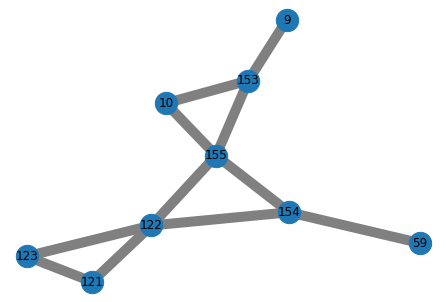

In [73]:
print("Draw subgraph using networkx")

def graph_from_adj(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    return gr

nA = explainer.n_hops_A(2)
node_idx_new, sub_A, sub_X, neighbors = explainer.extract_n_hops_neighbors(nA,TARGET_NODE)
plot_G = graph_from_adj(sub_A)
label_dict = dict(zip(range(len(neighbors.tolist())),neighbors.tolist()))

pos=nx.spring_layout(plot_G)

nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

In [74]:
from matplotlib import pyplot as plt

In [75]:
edge_strength = {(u, v):2*np.abs(0.5-round(explainer.pgm_conditional_prob(v, pgm_explanation, [u]), 2)) for u,v in pgm_explanation.edges()}

edge_weight = {}
for plot_edge in list(plot_G.edges()):
    edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
    plot_key = (plot_edge[0],plot_edge[1])
    edge_weight[plot_key] = 0
    if edge_key in edge_strength.keys():
        edge_weight[plot_key] = edge_strength[edge_key]
    edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
    if edge_key_rev in edge_strength.keys():
        edge_weight[plot_key] = edge_strength[edge_key_rev]

inv_label_dict = dict(zip(neighbors.tolist(),range(len(neighbors.tolist()))))

pgm_only_edges = []

for edge_key in edge_strength.keys():
    plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
    rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
    if plot_key not in list(plot_G.edges()):
        if rev_plot_key not in list(plot_G.edges()):
            pgm_only_edges.append(plot_key)
            edge_weight[plot_key] = edge_strength[edge_key]

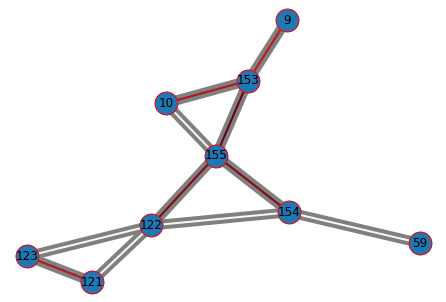

In [76]:
nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist = plot_G.edges(),
                               edge_color=[edge_weight[e] for e in plot_G.edges()],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=520)
nodes.set_edgecolor('red')

edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist =pgm_only_edges,
                               edge_color=[edge_weight[e] for e in pgm_only_edges],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


/tmp/ipykernel_16754/3100900029.py:172: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  XZ_state_counts = XYZ_state_counts.sum(axis=1,level = list( range(1,len(Z)+1)) )  # marginalize out Y
  0%|                                    | 2/1000000 [00:00<11:08:21, 24.94it/s]


PGM Nodes:  ['9', '10', '121', '122', '153', '155']
PGM Edges:  [('9', '155'), ('10', '153'), ('10', '155'), ('121', '155'), ('122', '155'), ('153', '9')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

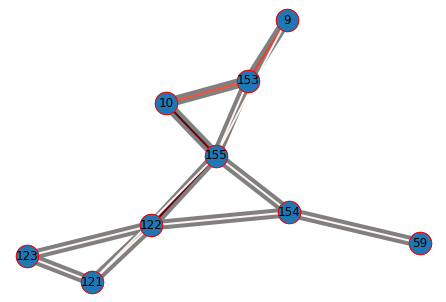

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<21:26:21, 12.96it/s]


PGM Nodes:  ['9', '10', '59', '121', '122', '153', '154', '155']
PGM Edges:  [('10', '153'), ('10', '155'), ('121', '155'), ('122', '155'), ('153', '9'), ('153', '155'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

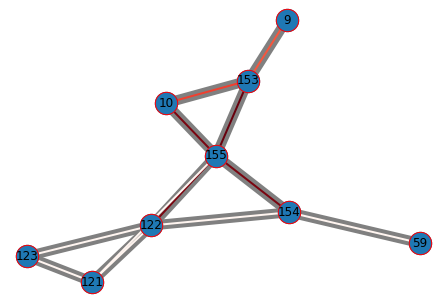

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<11:02:04, 25.17it/s]

PGM Nodes:  ['10', '121', '122', '123', '154', '155']
PGM Edges:  [('121', '154'), ('121', '122'), ('121', '155'), ('122', '155'), ('123', '155'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

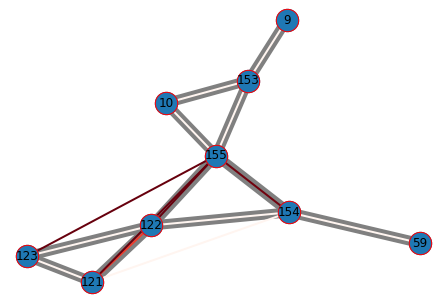

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<15:43:13, 17.67it/s]

PGM Nodes:  ['9', '10', '121', '123', '153', '154', '155']
PGM Edges:  [('10', '153'), ('10', '155'), ('121', '155'), ('123', '121'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

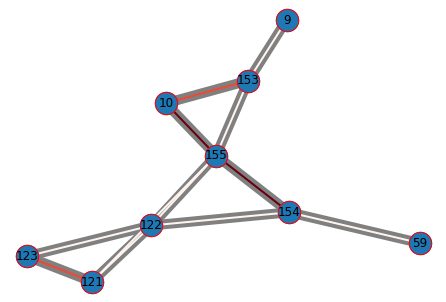

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<15:50:52, 17.53it/s]


PGM Nodes:  ['10', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('10', '153'), ('10', '155'), ('121', '123'), ('122', '155'), ('153', '155'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

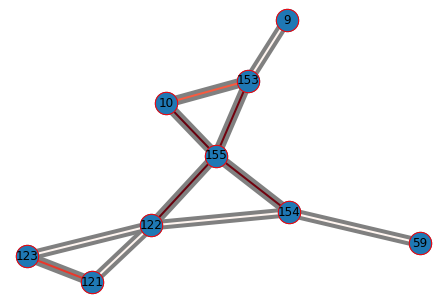

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 3/1000000 [00:00<20:15:35, 13.71it/s]


PGM Nodes:  ['9', '10', '59', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('9', '155'), ('10', '153'), ('10', '155'), ('121', '155'), ('122', '121'), ('123', '155'), ('154', '122'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

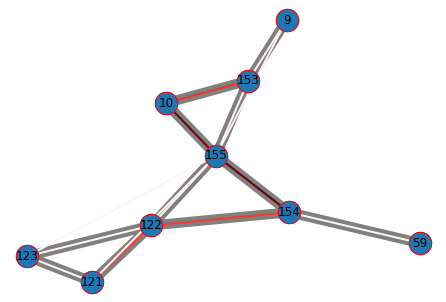

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<11:09:28, 24.90it/s]

PGM Nodes:  ['10', '59', '121', '122', '123', '155']
PGM Edges:  [('10', '155'), ('59', '155'), ('121', '122'), ('121', '155'), ('122', '123'), ('122', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

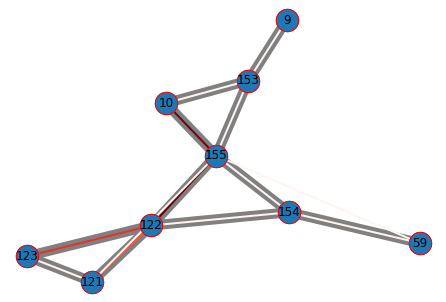

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                               | 0/1000000 [00:00<?, ?it/s]

PGM Nodes:  ['10', '59', '121', '122', '123', '155']
PGM Edges:  [('59', '155'), ('121', '155'), ('122', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

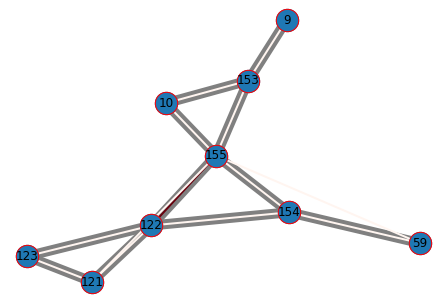

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                     | 3/1000000 [00:00<8:24:52, 33.01it/s]

PGM Nodes:  ['59', '121', '122', '123', '154', '155']
PGM Edges:  [('122', '123'), ('122', '154'), ('122', '155'), ('123', '121'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

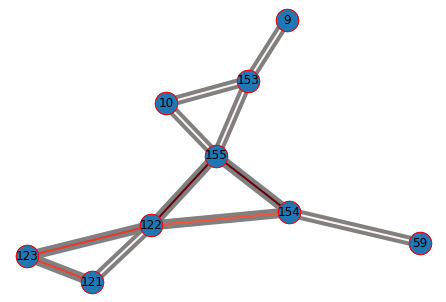

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<15:48:36, 17.57it/s]


PGM Nodes:  ['59', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('121', '155'), ('122', '121'), ('122', '155'), ('123', '155'), ('154', '122'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

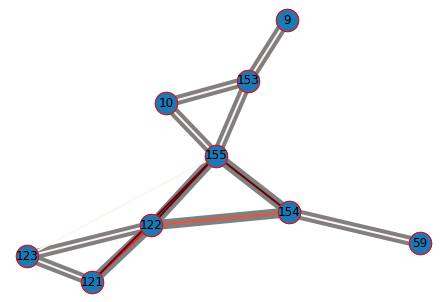

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 4/1000000 [00:00<13:12:25, 21.03it/s]


PGM Nodes:  ['10', '59', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('10', '153'), ('59', '155'), ('121', '122'), ('121', '155'), ('122', '154'), ('122', '123'), ('122', '155'), ('154', '155')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

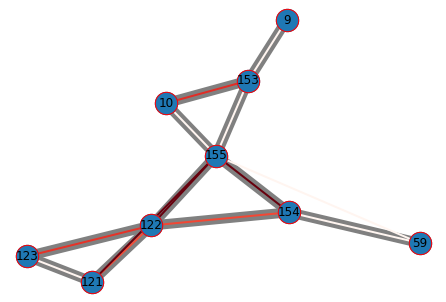

Explainer settings
\ A dim:  (156, 156)
\ X dim:  torch.Size([156])
\ Number of layers:  2
\ Perturbation mode:  0
\ Print result:  1
Generate the PGM


  0%|                                    | 2/1000000 [00:00<21:36:21, 12.86it/s]


PGM Nodes:  ['9', '10', '121', '122', '123', '153', '154', '155']
PGM Edges:  [('9', '155'), ('10', '153'), ('10', '155'), ('122', '155'), ('153', '9')]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

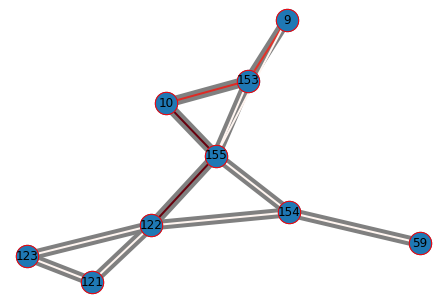

In [78]:
dependent_neighbors = []
for probe_snapshot in range(0,12):

    hidden_state = torch.zeros(batch_size, num_nodes * hidden_dim).type_as(inputs)
    output = None
    for i in range(probe_snapshot):
        if i == probe_snapshot - 1:
            dest_model = models.tgcn.TGCNCell_clone(adj, input_dim, hidden_dim, hidden_state)
            dest_model.eval()    
            clone_layers = []
            for item in source_task.model.tgcn_cell._modules.items():
                clone_layers.append(item[0])

            for layer in clone_layers:
                if hasattr(getattr(dest_model, layer), 'weights'):
                    with torch.no_grad():
                        getattr(dest_model, layer).weights.copy_(getattr(source_model, layer).weights)
                if hasattr(getattr(dest_model, layer), 'biases'):
                    with torch.no_grad():
                        getattr(dest_model, layer).biases.copy_(getattr(source_model, layer).biases)

        output, hidden_state = source_model(inputs[:, i, :], hidden_state) 
        
    input_features = inputs[:, probe_snapshot-1, :]
    # Init
    explainer = Node_Explainer(dest_model, dest_task, adj, input_features[0], 0, 2)
    # Explain
    pgm_nodes, data, pgm_stats = explainer.explain_tgcn_node(TARGET_NODE, 0.01, 0.2, 500, 0.001)
    
    print("Generate the PGM")
    pgm_explanation = explainer.pgm_generate(TARGET_NODE, data, stats, pgm_nodes)
    print("PGM Nodes: ", pgm_explanation.nodes())
    print("PGM Edges: ", pgm_explanation.edges())
    
    
    edge_strength = {(u, v):2*np.abs(0.5-round(explainer.pgm_conditional_prob(v, pgm_explanation, [u]), 2)) for u,v in pgm_explanation.edges()}
    
    edge_weight = {}
    for plot_edge in list(plot_G.edges()):
        edge_key = (str(label_dict[plot_edge[0]]),str(label_dict[plot_edge[1]]))
        plot_key = (plot_edge[0],plot_edge[1])
        edge_weight[plot_key] = 0
        if edge_key in edge_strength.keys():
            edge_weight[plot_key] = edge_strength[edge_key]
        edge_key_rev = (str(label_dict[plot_edge[1]]),str(label_dict[plot_edge[0]]))
        if edge_key_rev in edge_strength.keys():
            edge_weight[plot_key] = edge_strength[edge_key_rev]
            
    pgm_only_edges = []

    for edge_key in edge_strength.keys():
        plot_key = (inv_label_dict[int(edge_key[0])], inv_label_dict[int(edge_key[1])])
        rev_plot_key = (inv_label_dict[int(edge_key[1])], inv_label_dict[int(edge_key[0])])
        if plot_key not in list(plot_G.edges()):
            if rev_plot_key not in list(plot_G.edges()):
                pgm_only_edges.append(plot_key)
                edge_weight[plot_key] = edge_strength[edge_key]

        plt.figure()
#         print("Draw pgm explaination using networkx")
    
    nx.draw(plot_G, pos=pos, node_size=500, labels=label_dict, with_labels=True, width = 10, edge_color = 'gray')

    edges = nx.draw_networkx_edges(plot_G,
                               pos=pos,
                               edgelist = plot_G.edges(),
                               edge_color=[edge_weight[e] for e in plot_G.edges()],
                               edge_cmap= plt.cm.Reds,
                               alpha=1.0,
                               width = 2)

    nodes = nx.draw_networkx_nodes(plot_G, pos, node_size=500)
    nodes.set_edgecolor('red')
    
    

    edges = nx.draw_networkx_edges(plot_G,
                                   pos=pos,
                                   edgelist =pgm_only_edges,
                                   edge_color=[edge_weight[e] for e in pgm_only_edges],
                                   edge_cmap= plt.cm.Reds,
                                   alpha=1.0,
                                   width = 2)
    
#     nx.draw(pgm_explanation, with_labels=True)
    plt.show()
    
    dependent_neighbors.append(pgm_nodes)

In [79]:
dependent_neighbors

[[9, 10, 121, 122, 153, 155],
 [9, 10, 59, 121, 122, 153, 154, 155],
 [10, 121, 122, 123, 154, 155],
 [9, 10, 121, 123, 153, 154, 155],
 [10, 121, 122, 123, 153, 154, 155],
 [9, 10, 59, 121, 122, 123, 153, 154, 155],
 [10, 59, 121, 122, 123, 155],
 [10, 59, 121, 122, 123, 155],
 [59, 121, 122, 123, 154, 155],
 [59, 121, 122, 123, 153, 154, 155],
 [10, 59, 121, 122, 123, 153, 154, 155],
 [9, 10, 121, 122, 123, 153, 154, 155]]

In [ ]:
# dependent_neighbors